In [71]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

import sklearn.linear_model
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [72]:
class NeuralNet:
    
    """
    NN for binary classification
    Attributes:
    ...
    """
 
    def __init__(self, normalize = True, learning_rate = 0.01, ammount_iter = 30000, hidden_layer_sizes=(100,), e=1e-6):
        self.learning_rate = learning_rate
        self.ammount_iter = ammount_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.e = e
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def __initialize_parameters(self, n_x, hidden_layers, n_y):
        np.random.seed(1)
        W = list()
        b = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        
        for l in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[l], hidden_layers[l-1]) / np.sqrt(
                hidden_layers[l - 1]))
            b.append(np.zeros((hidden_layers[l], 1)))

        self.parameters = {"W" : W, "b" : b}
    
    def __forward_process(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
               
        for l in range(0, self.n_layers-1):
            if l == 0:
                Z.append(np.dot(W[l], X) + b[l])
            else:
                Z.append(np.dot(W[l], A[l-1]) + b[l])
            A.append(self.__sigmoid(Z[l]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.softmax(Z[-1]))
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __backward_process(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
              
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for l in range(self.n_layers-1, 0, -1):
            dZ[l-1] = np.multiply(dA[l], self.__sigmoid_derivative(Z[l-1]))
            if l-1 == 0:
                dW[l-1] = 1. / m * np.dot(dZ[l-1], X.T)
            else:
                dW[l-1] = 1. / m * np.dot(dZ[l-1], A[l-2].T)
            db[l-1] = 1. / m * np.sum(dZ[l-1], axis = 1, keepdims = True) 
            dA[l-1] = np.dot(W[l-1].T, dZ[l-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def compute_cost(self, A, Y):
        return -np.mean(Y.T * np.log(A.T+ 1e-8))
    
    def cross_entropy(self, A, Y):
        return - np.sum(np.log(A) * (Y), axis=1)
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        cost_history = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes, n_y)

        for i in range(self.ammount_iter):
            self.n_iter = i
            A, cache = self.__forward_process(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_process(X, Y, cache)

            self.__update_parameters(grads)
            
            cost_history.append(cost)
            
            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 100 == 0:
                costs.append(cost)
  
            if i > 1 and abs(cost-cost_history[-2]) < self.e:
                print('Stopping gradient descent ...')
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_process(X)[0]
        
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.to_classlabel(positive_probs)
        return y_pred  

    def to_classlabel(self, z):
        return z.argmax(axis=1)

In [73]:

HEADERS = [
    'From', 'Subject', 'To', 'Reply-To', 'In-Reply-To', 'Apparently-To',
    'Original-Sender', 'Originator', 'Moderator', 'Organization', 'Keywords',
    'Distribution', 'NNTP-Posting-Host', 'Lines', 'Summary', 'Supersedes',
    'X-Bytes', 'X-Disclaimer', 'X-Mailer', 'X-Newsreader', 'X-News-Reader',
    'X-Gated-By', 'X-Added', 'X-Status',
    'OD-Comment-To', 'Expires', 'Disclaimer', 'Article-I.D.', 
    'News-Software',  'Nf-ID', 'Mime-Version'
]

RE_EMAIL = re.compile('<?.*@.*>?', re.M)
RE_LINE_BREAK = re.compile('\\n+', re.M)
RE_CITATION = re.compile('^.*writes:$', re.M)
RE_CITATION_QUOTES = re.compile('(\W+|^)(\|>|>|\|)+', re.M)
RE_HEADERS = re.compile('^(%s):.*$' % '|'.join(HEADERS), re.M|re.I)
def _clean(docs):
    docs = map(rm_headers, docs)
    docs = map(rm_citation, docs)
    docs = map(rm_citation_quotes, docs)
    docs = map(rm_email, docs)
    docs = map(rm_line_break, docs)
    
    return list(docs)

def rm_citation(doc):
    return RE_CITATION.sub('', doc)

def rm_citation_quotes(doc):
    return RE_CITATION_QUOTES.sub(r'\1', doc)

def rm_email(doc):
    return RE_EMAIL.sub('<email>', doc)

def rm_line_break(doc):
    return RE_LINE_BREAK.sub(' ', doc).strip('\n\t ')

def rm_headers(doc):
    return RE_HEADERS.sub('', doc)

In [74]:
ng = fetch_20newsgroups(subset="all", shuffle=False)
df=pd.DataFrame.from_dict({
        'text': _clean(ng.data),
        'group': np.take(ng.target_names, ng.target)
    })

In [75]:
type(ng)

sklearn.utils.Bunch

In [76]:
len(ng.data)

18846

In [77]:
df.head(10)

,text,group
0,morgan and guzman will have era's 1 run higher...,rec.sport.baseball
1,"Well, I just got my Centris 610 yesterday. It...",comp.sys.mac.hardware
2,History and classical methods. Modern methods....,sci.crypt
3,ATTENTION: Mac Quadra owners: Many storage ind...,comp.sys.mac.hardware
4,To show that the examples I and others have pr...,alt.atheism
5,Help!!! I have an ADB graphicsd tablet which I...,comp.sys.mac.hardware
6,"Hello world, I want to write my Xt-application...",comp.windows.x
7,<email> Hi. > I use Emacs and I want ...,comp.windows.x
8,Does anyone on this newsgroup happen to know W...,sci.med
9,X-Posted-From: britain.madvlsi.columbia.edu Hi...,sci.electronics


In [78]:
print(ng.data[1])

From: gnelson@pion.rutgers.edu (Gregory Nelson)
Subject: Thanks Apple: Free Ethernet on my C610!
Article-I.D.: pion.Apr.6.12.05.34.1993.11732
Organization: Rutgers Univ., New Brunswick, N.J.
Lines: 26


	Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substituted one _with_ ethernet.
He wanted to know if that would be "alright with me"!!!  They must
be backlogged on Centri w/out ethernet so they're just shipping them
with!  

	Anyway, I'm very happy with the 610 with a few exceptions.  
Being nosy, I decided to open it up _before_ powering it on for the first
time.  The SCSI cable to the hard drive was only partially connected
(must have come loose in shipping).  No big deal, but I would have been
pissed if I tried to boot it and it wouldn't come up!
	The hard drive also has an annoying high pitch

In [79]:
df.describe(include='all')

,text,group
count,18846,18846
unique,18750,20
top,,rec.sport.hockey
freq,30,999


Split data

In [80]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.group)


In [81]:
train.shape

(15076, 2)

In [82]:
test.shape

(3770, 2)

In [83]:
train.group.value_counts()

rec.sport.hockey            799
soc.religion.christian      798
rec.motorcycles             797
rec.sport.baseball          795
sci.crypt                   793
rec.autos                   792
sci.med                     792
comp.windows.x              790
sci.space                   790
comp.os.ms-windows.misc     788
sci.electronics             787
comp.sys.ibm.pc.hardware    786
misc.forsale                780
comp.graphics               778
comp.sys.mac.hardware       770
talk.politics.mideast       752
talk.politics.guns          728
alt.atheism                 639
talk.politics.misc          620
talk.religion.misc          502
Name: group, dtype: int64

In [84]:
test.group.value_counts()

rec.sport.hockey            200
rec.motorcycles             199
soc.religion.christian      199
rec.sport.baseball          199
rec.autos                   198
comp.windows.x              198
sci.med                     198
sci.crypt                   198
sci.electronics             197
sci.space                   197
comp.os.ms-windows.misc     197
comp.sys.ibm.pc.hardware    196
comp.graphics               195
misc.forsale                195
comp.sys.mac.hardware       193
talk.politics.mideast       188
talk.politics.guns          182
alt.atheism                 160
talk.politics.misc          155
talk.religion.misc          126
Name: group, dtype: int64

In [85]:
label_encoder = LabelEncoder().fit(train.group)
label_encoder.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

In [86]:
tfidf = TfidfVectorizer(max_features=10000).fit(train.text)
len(tfidf.vocabulary_)

10000

In [87]:
X_train = tfidf.transform(train.text).toarray()

X_test = tfidf.transform(test.text).toarray()

In [88]:
X_train.shape

(15076, 10000)

In [89]:
X_test.shape

(3770, 10000)

In [90]:
label_encoder = LabelEncoder().fit(train.group)

In [91]:
Y_train = label_encoder.transform(train.group)

Y_test = label_encoder.transform(test.group)

In [92]:
Y_train.shape

(15076,)

In [93]:
Y_test.shape

(3770,)

In [94]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, Y_train)

In [95]:
print(classification_report(Y_train, clf.predict(X_train), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.88      0.72      0.79       639
           comp.graphics       0.84      0.85      0.85       778
 comp.os.ms-windows.misc       0.83      0.86      0.85       788
comp.sys.ibm.pc.hardware       0.79      0.88      0.83       786
   comp.sys.mac.hardware       0.92      0.89      0.91       770
          comp.windows.x       0.92      0.88      0.90       790
            misc.forsale       0.90      0.80      0.85       780
               rec.autos       0.91      0.94      0.92       792
         rec.motorcycles       0.96      0.95      0.96       797
      rec.sport.baseball       0.96      0.97      0.97       795
        rec.sport.hockey       0.94      0.98      0.96       799
               sci.crypt       0.91      0.95      0.93       793
         sci.electronics       0.88      0.84      0.86       787
                 sci.med       0.94      0.95      0.95       792
         

test

In [96]:
print(classification_report(Y_test, clf.predict(X_test), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.79      0.58      0.67       160
           comp.graphics       0.72      0.79      0.76       195
 comp.os.ms-windows.misc       0.77      0.77      0.77       197
comp.sys.ibm.pc.hardware       0.69      0.79      0.73       196
   comp.sys.mac.hardware       0.85      0.77      0.81       193
          comp.windows.x       0.84      0.82      0.83       198
            misc.forsale       0.89      0.75      0.81       195
               rec.autos       0.87      0.86      0.86       198
         rec.motorcycles       0.88      0.90      0.89       199
      rec.sport.baseball       0.95      0.95      0.95       199
        rec.sport.hockey       0.93      0.93      0.93       200
               sci.crypt       0.85      0.91      0.88       198
         sci.electronics       0.82      0.77      0.79       197
                 sci.med       0.94      0.88      0.91       198
         

In [97]:
pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(Y_test, pred)

0.806631299734748

In [98]:
cls = NeuralNet(normalize = True, learning_rate = 0.1, ammount_iter = 1000, hidden_layer_sizes=(50, ), e=1e-6)

In [99]:
encoder = OneHotEncoder()
Y_train_e = encoder.fit_transform(Y_train.reshape((Y_train.shape[0], 1))).toarray()

c:\nastia\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
c:\nastia\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in exp


0-th iteration: 0.15935598216698577
100-th iteration: 0.06964081425896529
200-th iteration: 0.03175556067913341
300-th iteration: 0.022213174500235473
400-th iteration: 0.018583923907584156
Stopping gradient descent ...


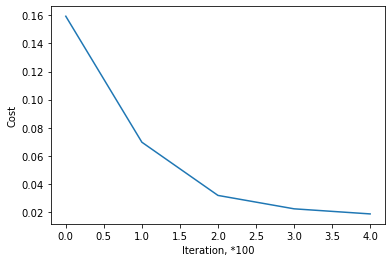

In [100]:
cls.fit(X_train, Y_train_e)

In [102]:
y_train_pred = np.array(cls.predict(X_train))
print(Y_train.shape)
accuracy_ts = accuracy_score(Y_train, y_train_pred)
precision_ts = precision_score(Y_train, y_train_pred, average='micro')
recall_ts = recall_score(Y_train, y_train_pred, average='micro')
print('Accuracy: ', accuracy_ts)
print('Precision: ', precision_ts)
print('Recall: ', recall_ts)

c:\nastia\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


(15076,)
Accuracy:  0.9754576810825153
Precision:  0.9754576810825153
Recall:  0.9754576810825153
